In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.0001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_00001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/632 [..............................] - ETA: 12:04 - loss: 0.0462 - STD: 2.6089e-04 - MAE: 0.2070

 12/632 [..............................] - ETA: 2s - loss: 0.0217 - STD: 3.5005e-04 - MAE: 0.1219   

 24/632 [>.............................] - ETA: 2s - loss: 0.0182 - STD: 3.6714e-04 - MAE: 0.0919

 36/632 [>.............................] - ETA: 2s - loss: 0.0166 - STD: 4.3533e-04 - MAE: 0.0826

 48/632 [=>............................] - ETA: 2s - loss: 0.0155 - STD: 6.0617e-04 - MAE: 0.0810

 58/632 [=>............................] - ETA: 2s - loss: 0.0150 - STD: 7.8914e-04 - MAE: 0.0792

 68/632 [==>...........................] - ETA: 2s - loss: 0.0146 - STD: 0.0010 - MAE: 0.0773    

 78/632 [==>...........................] - ETA: 2s - loss: 0.0142 - STD: 0.0013 - MAE: 0.0761

 88/632 [===>..........................] - ETA: 2s - loss: 0.0140 - STD: 0.0016 - MAE: 0.0752

 99/632 [===>..........................] - ETA: 2s - loss: 0.0137 - STD: 0.0020 - MAE: 0.0742

111/632 [====>.........................] - ETA: 2s - loss: 0.0135 - STD: 0.0025 - MAE: 0.0736

122/632 [====>.........................] - ETA: 2s - loss: 0.0133 - STD: 0.0031 - MAE: 0.0729

132/632 [=====>........................] - ETA: 2s - loss: 0.0131 - STD: 0.0038 - MAE: 0.0722

142/632 [=====>........................] - ETA: 2s - loss: 0.0129 - STD: 0.0047 - MAE: 0.0716

152/632 [======>.......................] - ETA: 2s - loss: 0.0127 - STD: 0.0057 - MAE: 0.0708

162/632 [======>.......................] - ETA: 2s - loss: 0.0125 - STD: 0.0070 - MAE: 0.0700

164/632 [======>.......................] - ETA: 3s - loss: 0.0124 - STD: 0.0073 - MAE: 0.0698

174/632 [=======>......................] - ETA: 3s - loss: 0.0122 - STD: 0.0090 - MAE: 0.0689

184/632 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 0.0110 - MAE: 0.0680

194/632 [========>.....................] - ETA: 3s - loss: 0.0116 - STD: 0.0133 - MAE: 0.0670

204/632 [========>.....................] - ETA: 3s - loss: 0.0113 - STD: 0.0158 - MAE: 0.0662

214/632 [=========>....................] - ETA: 3s - loss: 0.0111 - STD: 0.0184 - MAE: 0.0653

224/632 [=========>....................] - ETA: 3s - loss: 0.0108 - STD: 0.0209 - MAE: 0.0645

234/632 [==========>...................] - ETA: 2s - loss: 0.0106 - STD: 0.0234 - MAE: 0.0637

244/632 [==========>...................] - ETA: 2s - loss: 0.0103 - STD: 0.0258 - MAE: 0.0629

254/632 [===========>..................] - ETA: 2s - loss: 0.0101 - STD: 0.0280 - MAE: 0.0621

264/632 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 0.0302 - MAE: 0.0614

274/632 [============>.................] - ETA: 2s - loss: 0.0096 - STD: 0.0323 - MAE: 0.0606

284/632 [============>.................] - ETA: 2s - loss: 0.0094 - STD: 0.0342 - MAE: 0.0599

294/632 [============>.................] - ETA: 2s - loss: 0.0093 - STD: 0.0361 - MAE: 0.0593

304/632 [=============>................] - ETA: 2s - loss: 0.0091 - STD: 0.0379 - MAE: 0.0586

314/632 [=============>................] - ETA: 2s - loss: 0.0089 - STD: 0.0396 - MAE: 0.0580

324/632 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0413 - MAE: 0.0574

335/632 [==============>...............] - ETA: 1s - loss: 0.0086 - STD: 0.0430 - MAE: 0.0568

345/632 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0445 - MAE: 0.0562

357/632 [===============>..............] - ETA: 1s - loss: 0.0082 - STD: 0.0462 - MAE: 0.0556

369/632 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0478 - MAE: 0.0550

381/632 [=================>............] - ETA: 1s - loss: 0.0079 - STD: 0.0491 - MAE: 0.0544

393/632 [=================>............] - ETA: 1s - loss: 0.0078 - STD: 0.0505 - MAE: 0.0538

405/632 [==================>...........] - ETA: 1s - loss: 0.0076 - STD: 0.0519 - MAE: 0.0533

417/632 [==================>...........] - ETA: 1s - loss: 0.0075 - STD: 0.0531 - MAE: 0.0528

429/632 [===================>..........] - ETA: 1s - loss: 0.0074 - STD: 0.0543 - MAE: 0.0523

441/632 [===================>..........] - ETA: 1s - loss: 0.0072 - STD: 0.0554 - MAE: 0.0519

454/632 [====================>.........] - ETA: 1s - loss: 0.0071 - STD: 0.0566 - MAE: 0.0514

467/632 [=====================>........] - ETA: 0s - loss: 0.0070 - STD: 0.0577 - MAE: 0.0509

480/632 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0589 - MAE: 0.0505

492/632 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0597 - MAE: 0.0501

504/632 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0607 - MAE: 0.0497

516/632 [=======================>......] - ETA: 0s - loss: 0.0066 - STD: 0.0616 - MAE: 0.0493

528/632 [========================>.....] - ETA: 0s - loss: 0.0065 - STD: 0.0624 - MAE: 0.0490

541/632 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0633 - MAE: 0.0486

554/632 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0641 - MAE: 0.0482

567/632 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0649 - MAE: 0.0479

580/632 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0657 - MAE: 0.0476

593/632 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0664 - MAE: 0.0472

605/632 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0671 - MAE: 0.0469

618/632 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0678 - MAE: 0.0466

631/632 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0685 - MAE: 0.0464

632/632 [==============================] - 5s 7ms/step - loss: 0.0058 - STD: 0.0685 - MAE: 0.0463 - val_loss: 0.0032 - val_STD: 0.0670 - val_MAE: 0.0379


Epoch 2/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0022 - STD: 0.1032 - MAE: 0.0322

 13/632 [..............................] - ETA: 2s - loss: 0.0024 - STD: 0.1013 - MAE: 0.0327 

 24/632 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0323

 34/632 [>.............................] - ETA: 2s - loss: 0.0023 - STD: 0.1011 - MAE: 0.0322

 45/632 [=>............................] - ETA: 2s - loss: 0.0023 - STD: 0.1008 - MAE: 0.0321

 58/632 [=>............................] - ETA: 2s - loss: 0.0022 - STD: 0.1009 - MAE: 0.0318

 70/632 [==>...........................] - ETA: 2s - loss: 0.0023 - STD: 0.1007 - MAE: 0.0319

 82/632 [==>...........................] - ETA: 2s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0318

 94/632 [===>..........................] - ETA: 2s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0318

106/632 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0318

118/632 [====>.........................] - ETA: 2s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0318

130/632 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1012 - MAE: 0.0317

142/632 [=====>........................] - ETA: 2s - loss: 0.0022 - STD: 0.1014 - MAE: 0.0316

154/632 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1013 - MAE: 0.0315

165/632 [======>.......................] - ETA: 2s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0315

175/632 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1015 - MAE: 0.0315

186/632 [=======>......................] - ETA: 2s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0314

198/632 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1016 - MAE: 0.0314

210/632 [========>.....................] - ETA: 1s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0313

222/632 [=========>....................] - ETA: 1s - loss: 0.0022 - STD: 0.1017 - MAE: 0.0313

235/632 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0312

248/632 [==========>...................] - ETA: 1s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0311

260/632 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1016 - MAE: 0.0311

272/632 [===========>..................] - ETA: 1s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0311

284/632 [============>.................] - ETA: 1s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0310

297/632 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1017 - MAE: 0.0309

308/632 [=============>................] - ETA: 1s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0309

318/632 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1018 - MAE: 0.0309

329/632 [==============>...............] - ETA: 1s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0308

340/632 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0308

350/632 [===============>..............] - ETA: 1s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0307

360/632 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1019 - MAE: 0.0307

371/632 [================>.............] - ETA: 1s - loss: 0.0021 - STD: 0.1020 - MAE: 0.0307

382/632 [=================>............] - ETA: 1s - loss: 0.0021 - STD: 0.1021 - MAE: 0.0307

392/632 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.1021 - MAE: 0.0306

404/632 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0306

417/632 [==================>...........] - ETA: 0s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0306

427/632 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1022 - MAE: 0.0305

437/632 [===================>..........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

447/632 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0305

457/632 [====================>.........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

467/632 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0304

477/632 [=====================>........] - ETA: 0s - loss: 0.0020 - STD: 0.1023 - MAE: 0.0304

487/632 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

497/632 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

508/632 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0303

519/632 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.1024 - MAE: 0.0302

530/632 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

541/632 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

552/632 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1025 - MAE: 0.0302

563/632 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

575/632 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

586/632 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

599/632 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1026 - MAE: 0.0301

609/632 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0301

620/632 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300

631/632 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300

632/632 [==============================] - 3s 5ms/step - loss: 0.0020 - STD: 0.1027 - MAE: 0.0300 - val_loss: 0.0020 - val_STD: 0.0760 - val_MAE: 0.0309


Epoch 3/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0016 - STD: 0.0924 - MAE: 0.0281

 11/632 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1024 - MAE: 0.0282 

 22/632 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1034 - MAE: 0.0285

 32/632 [>.............................] - ETA: 3s - loss: 0.0017 - STD: 0.1029 - MAE: 0.0284

 42/632 [>.............................] - ETA: 3s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0285

 53/632 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

 63/632 [=>............................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0285

 73/632 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

 84/632 [==>...........................] - ETA: 2s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0284

 96/632 [===>..........................] - ETA: 2s - loss: 0.0017 - STD: 0.1038 - MAE: 0.0283

108/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0283

120/632 [====>.........................] - ETA: 2s - loss: 0.0017 - STD: 0.1039 - MAE: 0.0282

132/632 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0283

142/632 [=====>........................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

153/632 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

164/632 [======>.......................] - ETA: 2s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0282

175/632 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0282

186/632 [=======>......................] - ETA: 2s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

196/632 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

206/632 [========>.....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

216/632 [=========>....................] - ETA: 2s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

226/632 [=========>....................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

236/632 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0282

246/632 [==========>...................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

256/632 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0282

266/632 [===========>..................] - ETA: 1s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0281

276/632 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

286/632 [============>.................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

296/632 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

306/632 [=============>................] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

316/632 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

326/632 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

337/632 [==============>...............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

349/632 [===============>..............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

361/632 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

373/632 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

384/632 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0281

394/632 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

404/632 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

414/632 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

424/632 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0281

434/632 [===================>..........] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

444/632 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

455/632 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

465/632 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

475/632 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0280

486/632 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

496/632 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

508/632 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0280

520/632 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

531/632 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

543/632 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

556/632 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

567/632 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

578/632 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

588/632 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

598/632 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1048 - MAE: 0.0279

608/632 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

619/632 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

631/632 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279

632/632 [==============================] - 3s 5ms/step - loss: 0.0017 - STD: 0.1047 - MAE: 0.0279 - val_loss: 0.0017 - val_STD: 0.0773 - val_MAE: 0.0288


Epoch 4/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0017 - STD: 0.1089 - MAE: 0.0280

 11/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1076 - MAE: 0.0273 

 22/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1066 - MAE: 0.0274

 34/632 [>.............................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

 45/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0274

 57/632 [=>............................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

 68/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

 80/632 [==>...........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

 92/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

104/632 [===>..........................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0274

116/632 [====>.........................] - ETA: 2s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0273

127/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0273

138/632 [=====>........................] - ETA: 2s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0273

150/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

162/632 [======>.......................] - ETA: 2s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

174/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

186/632 [=======>......................] - ETA: 2s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0273

198/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0273

210/632 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

222/632 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0273

234/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

246/632 [==========>...................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

258/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

270/632 [===========>..................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

282/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0273

294/632 [============>.................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

306/632 [=============>................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

318/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

330/632 [==============>...............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

342/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

354/632 [===============>..............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

366/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

378/632 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

390/632 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

402/632 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

414/632 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

426/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

438/632 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

450/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1056 - MAE: 0.0272

462/632 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

474/632 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

486/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

497/632 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

508/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

520/632 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0272

532/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0272

544/632 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0271

556/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

568/632 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

580/632 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

592/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

604/632 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0271

616/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

628/632 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271

632/632 [==============================] - 3s 5ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0271 - val_loss: 0.0017 - val_STD: 0.0782 - val_MAE: 0.0287


Epoch 5/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0017 - STD: 0.0960 - MAE: 0.0283

 12/632 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0271 

 22/632 [>.............................] - ETA: 3s - loss: 0.0016 - STD: 0.1058 - MAE: 0.0271

 32/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0270

 42/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

 52/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0268

 62/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

 73/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

 83/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

 93/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0268

103/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

114/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

124/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

134/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0267

144/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

154/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

164/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

174/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

185/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0268

196/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

207/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

217/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

227/632 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

237/632 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

247/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

257/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

267/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

277/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

288/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

298/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

308/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

319/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

330/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

340/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

351/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

362/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

372/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

383/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

393/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

403/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

414/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

425/632 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

435/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

446/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

458/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

471/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

482/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

495/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

507/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

520/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

555/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

566/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

578/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

590/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

602/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

614/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

625/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267 - val_loss: 0.0020 - val_STD: 0.0821 - val_MAE: 0.0310


Epoch 6/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.1091 - MAE: 0.0271

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0266 

 22/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

 34/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

 46/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

 58/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

 70/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 82/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

 94/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

105/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

116/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

128/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0265

140/632 [=====>........................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

152/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

164/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

176/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

188/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

200/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

212/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

223/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

235/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

247/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

259/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

272/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

283/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

294/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

306/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

318/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

330/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

342/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

354/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

366/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

379/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

392/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

404/632 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

415/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

426/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

438/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

450/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

462/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

474/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

486/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

497/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

508/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

520/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

532/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

544/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

557/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

569/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

581/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

593/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

605/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

617/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

627/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0019 - val_STD: 0.0831 - val_MAE: 0.0301


Epoch 7/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0014 - STD: 0.1150 - MAE: 0.0265

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1088 - MAE: 0.0267 

 21/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1077 - MAE: 0.0268

 31/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0268

 41/632 [>.............................] - ETA: 3s - loss: 0.0015 - STD: 0.1075 - MAE: 0.0267

 52/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1072 - MAE: 0.0266

 65/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1067 - MAE: 0.0265

 78/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0265

 91/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0265

104/632 [===>..........................] - ETA: 2s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0264

116/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0264

128/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

141/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0263

153/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

166/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0264

179/632 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

192/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1061 - MAE: 0.0264

205/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0263

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

230/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

242/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

254/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

266/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

278/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

290/632 [============>.................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

302/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

315/632 [=============>................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0265

327/632 [==============>...............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

340/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

353/632 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

366/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

379/632 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0264

392/632 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

404/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

416/632 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

428/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

440/632 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

452/632 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

464/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

476/632 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

488/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

500/632 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

512/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

524/632 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

536/632 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

548/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

560/632 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

572/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

584/632 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

596/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

608/632 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0264

620/632 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

632/632 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264

632/632 [==============================] - 3s 5ms/step - loss: 0.0015 - STD: 0.1058 - MAE: 0.0264 - val_loss: 0.0016 - val_STD: 0.0800 - val_MAE: 0.0282


Epoch 8/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0014 - STD: 0.0954 - MAE: 0.0257

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1042 - MAE: 0.0262 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0262

 37/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0262

 50/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0262

 63/632 [=>............................] - ETA: 2s - loss: 0.0015 - STD: 0.1045 - MAE: 0.0263

 75/632 [==>...........................] - ETA: 2s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0263

 85/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0263

 95/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0263

105/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0263

115/632 [====>.........................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

125/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0263

137/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0263

148/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0263

160/632 [======>.......................] - ETA: 2s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

172/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

184/632 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

194/632 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

205/632 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

215/632 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

225/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0263

236/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

248/632 [==========>...................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0263

260/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

272/632 [===========>..................] - ETA: 1s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0263

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

296/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

319/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

340/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

350/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

360/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

370/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

390/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

401/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

411/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

421/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

431/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

441/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

499/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

511/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

547/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

559/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0263

571/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

608/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

620/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0263

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0818 - val_MAE: 0.0288


Epoch 9/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0012 - STD: 0.1085 - MAE: 0.0247

 11/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1036 - MAE: 0.0255 

 22/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

 32/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

 54/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

 65/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 78/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

 90/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

102/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0261

114/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

125/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

137/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

149/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

161/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

173/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

183/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

194/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

204/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

215/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

228/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

240/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

261/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

273/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

285/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

318/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

328/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

338/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

349/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

369/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

389/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

399/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

409/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

419/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

429/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

439/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

482/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

492/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

503/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

514/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

524/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

556/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

576/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

586/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0261

607/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

618/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

628/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0018 - val_STD: 0.0835 - val_MAE: 0.0295


Epoch 10/10000


  1/632 [..............................] - ETA: 13s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0255

 13/632 [..............................] - ETA: 2s - loss: 0.0015 - STD: 0.1080 - MAE: 0.0264 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

 38/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

 49/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1068 - MAE: 0.0261

 61/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0261

 73/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

 85/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

 97/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

109/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0260

122/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

135/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

145/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

155/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

166/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0261

176/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0261

186/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

196/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

207/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

217/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

227/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

238/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

250/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

262/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0261

274/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

294/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

305/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

316/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

327/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

337/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

347/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

371/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

383/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

394/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

405/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

417/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

427/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

439/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

485/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

506/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

517/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

529/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

539/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0260

549/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

559/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

581/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

591/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0261

602/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

614/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

625/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261 - val_loss: 0.0019 - val_STD: 0.0828 - val_MAE: 0.0312


Epoch 11/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0264

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0256 

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0257

 37/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0257

 48/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0258

 60/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

 72/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

 82/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

 92/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

102/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

112/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

122/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

132/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0260

143/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

154/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

164/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

175/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

186/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

196/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

207/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

230/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

242/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

266/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

278/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

290/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

302/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

314/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

326/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

339/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

352/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

365/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

378/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

402/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

413/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

424/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

435/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

447/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

459/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

483/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

495/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

507/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

519/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

531/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

543/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

555/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

576/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

586/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

607/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

629/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259 - val_loss: 0.0016 - val_STD: 0.0807 - val_MAE: 0.0283


Epoch 12/10000


  1/632 [..............................] - ETA: 9s - loss: 0.0013 - STD: 0.1015 - MAE: 0.0251

 13/632 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 25/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0261

 36/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1069 - MAE: 0.0259

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1073 - MAE: 0.0259

 56/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0259

 66/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 76/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0259

 88/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0259

100/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0260

113/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

125/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

138/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

150/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

163/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

175/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0260

187/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0260

199/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

212/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

224/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

236/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

249/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

261/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

273/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

295/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

307/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

319/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

331/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

356/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

368/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

392/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

404/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

415/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

426/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

438/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

461/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

471/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

481/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

491/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

501/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

545/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

556/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

578/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

590/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

602/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0259

614/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

626/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258 - val_loss: 0.0015 - val_STD: 0.0802 - val_MAE: 0.0275


Epoch 13/10000


  1/632 [..............................] - ETA: 11s - loss: 0.0014 - STD: 0.1114 - MAE: 0.0260

 11/632 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0269 

 23/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0266

 35/632 [>.............................] - ETA: 2s - loss: 0.0015 - STD: 0.1065 - MAE: 0.0264

 48/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

 61/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

 74/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

 86/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

111/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

123/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

135/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

147/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

158/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

170/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

182/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

194/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0259

206/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

218/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

230/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

242/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0258

266/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0258

276/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

286/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

297/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

332/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

355/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

367/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

379/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

403/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

415/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

427/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

439/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

451/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

499/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

511/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

547/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

559/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

572/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

596/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

607/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

617/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

627/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257 - val_loss: 0.0015 - val_STD: 0.0812 - val_MAE: 0.0277


Epoch 14/10000


  1/632 [..............................] - ETA: 16s - loss: 0.0013 - STD: 0.1027 - MAE: 0.0262

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0254 

 24/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 35/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1056 - MAE: 0.0256

 46/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

 58/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

 70/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 82/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0257

 94/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0258

106/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

119/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

132/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

144/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

156/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

168/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0258

180/632 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

192/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

204/632 [========>.....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

216/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

229/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

242/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

254/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

266/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

278/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

291/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

304/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

317/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

330/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

343/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

355/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

366/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

377/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

388/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

400/632 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

411/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

423/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0257

436/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

448/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

460/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

470/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

480/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

492/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

502/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

512/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0257

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

556/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

566/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

577/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

588/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

599/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

611/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

624/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0845 - val_MAE: 0.0294


Epoch 15/10000


  1/632 [..............................] - ETA: 15s - loss: 0.0015 - STD: 0.1110 - MAE: 0.0264

 12/632 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0254 

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1037 - MAE: 0.0256

 33/632 [>.............................] - ETA: 3s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0256

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1050 - MAE: 0.0255

 53/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0254

 64/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

 76/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0255

 88/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

110/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

122/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

133/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

143/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

153/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

163/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

173/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

184/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

195/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

207/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

219/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

231/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

243/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

255/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

267/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

279/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

291/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

303/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

314/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

325/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

336/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

348/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

359/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

370/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

382/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

394/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

406/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

418/632 [==================>...........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

430/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

441/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

452/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

463/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

475/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

487/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

499/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

511/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

523/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

535/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

547/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

559/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

571/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

584/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

597/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

609/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

621/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256 - val_loss: 0.0016 - val_STD: 0.0827 - val_MAE: 0.0285


Epoch 16/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0259

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0253 

 22/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0254

 33/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0255

 43/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0256

 54/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

 64/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0256

 75/632 [==>...........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 87/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 98/632 [===>..........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

108/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

118/632 [====>.........................] - ETA: 2s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

129/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0256

140/632 [=====>........................] - ETA: 2s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

152/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

165/632 [======>.......................] - ETA: 2s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

178/632 [=======>......................] - ETA: 2s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

190/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

200/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

210/632 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

221/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

231/632 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

241/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

251/632 [==========>...................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

261/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

272/632 [===========>..................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

284/632 [============>.................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

296/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

308/632 [=============>................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

320/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

333/632 [==============>...............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

344/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

356/632 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

368/632 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

380/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

391/632 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

402/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

414/632 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

426/632 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

450/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

462/632 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

474/632 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

486/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

498/632 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

510/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

522/632 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

534/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

546/632 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

558/632 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

570/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

582/632 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

594/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

606/632 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

618/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

630/632 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

632/632 [==============================] - 3s 5ms/step - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256 - val_loss: 0.0018 - val_STD: 0.0843 - val_MAE: 0.0295


Epoch 17/10000


  1/632 [..............................] - ETA: 14s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0259

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0254 

 23/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

 35/632 [>.............................] - ETA: 2s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0257

 47/632 [=>............................] - ETA: 2s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0257

 59/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0256

 71/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0255

 83/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

 95/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0255

107/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0255

120/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0255

133/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0255

145/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0255

155/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0256

165/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0255

175/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0255

185/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0255

195/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

205/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

215/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

225/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

235/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

246/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

257/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

269/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

281/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

293/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0255

305/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0255

317/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0255

329/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

341/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0255

352/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

364/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

376/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

388/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

401/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

414/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

426/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

450/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0255

471/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

481/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

492/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0255

502/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

513/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

523/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

533/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

545/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

557/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

569/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

581/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

593/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

605/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

617/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

629/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254 - val_loss: 0.0018 - val_STD: 0.0841 - val_MAE: 0.0294


Epoch 18/10000


  1/632 [..............................] - ETA: 12s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0242

 11/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1046 - MAE: 0.0250 

 20/632 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1045 - MAE: 0.0250

 29/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1048 - MAE: 0.0251

 39/632 [>.............................] - ETA: 3s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

 49/632 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0251

 59/632 [=>............................] - ETA: 3s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0251

 71/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0251

 83/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0251

 96/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1050 - MAE: 0.0252

108/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1054 - MAE: 0.0252

120/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

132/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

144/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1057 - MAE: 0.0252

156/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0252

168/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

181/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

193/632 [========>.....................] - ETA: 2s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

205/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

217/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

229/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

241/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

253/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

265/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

277/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

289/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

301/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

313/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

325/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0253

337/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

349/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1061 - MAE: 0.0253

361/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

373/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

384/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

396/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

408/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

420/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

432/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

443/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

455/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

467/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

479/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

491/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

503/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

514/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

526/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

538/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

550/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

562/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

574/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

586/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

598/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

611/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0254

623/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0254 - val_loss: 0.0020 - val_STD: 0.0856 - val_MAE: 0.0310


Epoch 19/10000


  1/632 [..............................] - ETA: 10s - loss: 0.0015 - STD: 0.1076 - MAE: 0.0265

 12/632 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1077 - MAE: 0.0254 

 24/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1072 - MAE: 0.0253

 36/632 [>.............................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

 48/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

 60/632 [=>............................] - ETA: 2s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

 72/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 84/632 [==>...........................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0252

 94/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

105/632 [===>..........................] - ETA: 2s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0253

116/632 [====>.........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

128/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

139/632 [=====>........................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

150/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

162/632 [======>.......................] - ETA: 2s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

174/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

186/632 [=======>......................] - ETA: 2s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

197/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

208/632 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

220/632 [=========>....................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

232/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

244/632 [==========>...................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

256/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

268/632 [===========>..................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

280/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

292/632 [============>.................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

304/632 [=============>................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

316/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

328/632 [==============>...............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

340/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

352/632 [===============>..............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

365/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

378/632 [================>.............] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

390/632 [=================>............] - ETA: 1s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

403/632 [==================>...........] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

416/632 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

427/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

438/632 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

449/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

461/632 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

473/632 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

485/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

496/632 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

507/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0253

519/632 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

532/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

544/632 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

556/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

568/632 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

580/632 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

592/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0253

604/632 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

616/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

628/632 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253

632/632 [==============================] - 3s 5ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0253 - val_loss: 0.0016 - val_STD: 0.0838 - val_MAE: 0.0285


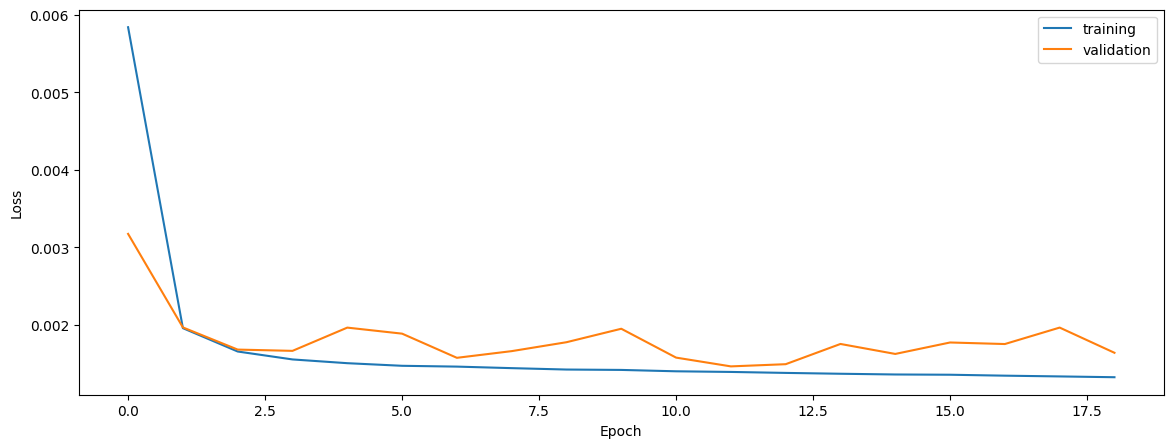

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9444904671687542
0.9559701262138651
0.9489185923932754


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9449916564288892
0.9531687881030261
0.9516195521794136


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9517812078063376
0.9553348249908784
0.9628366639160104


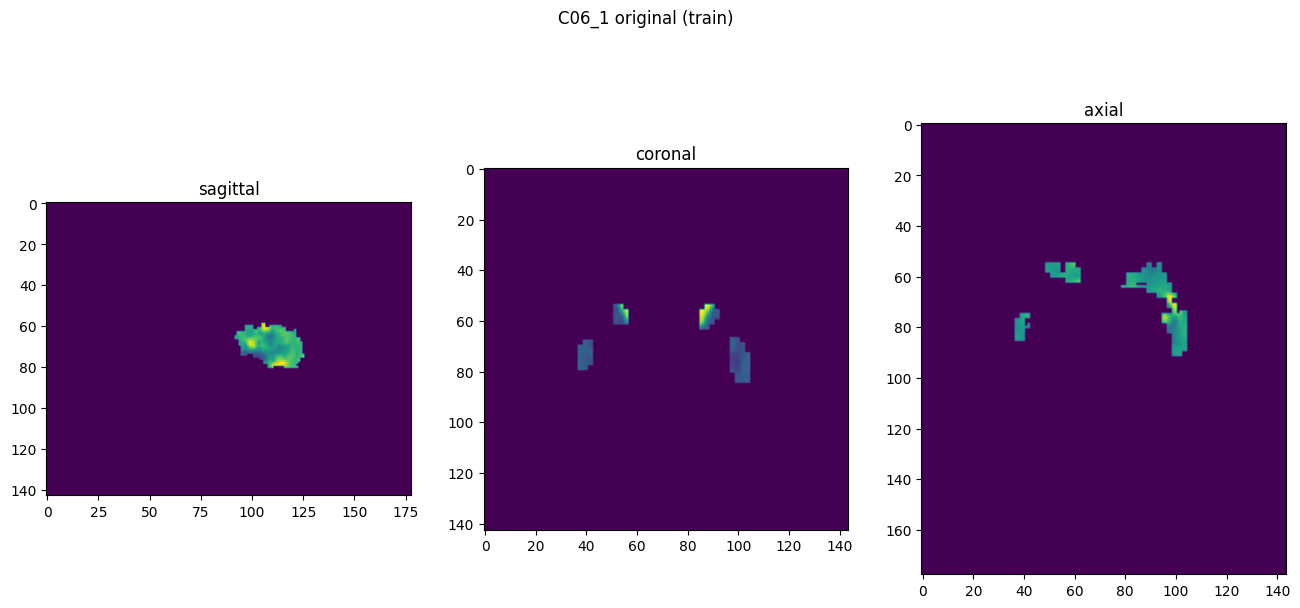

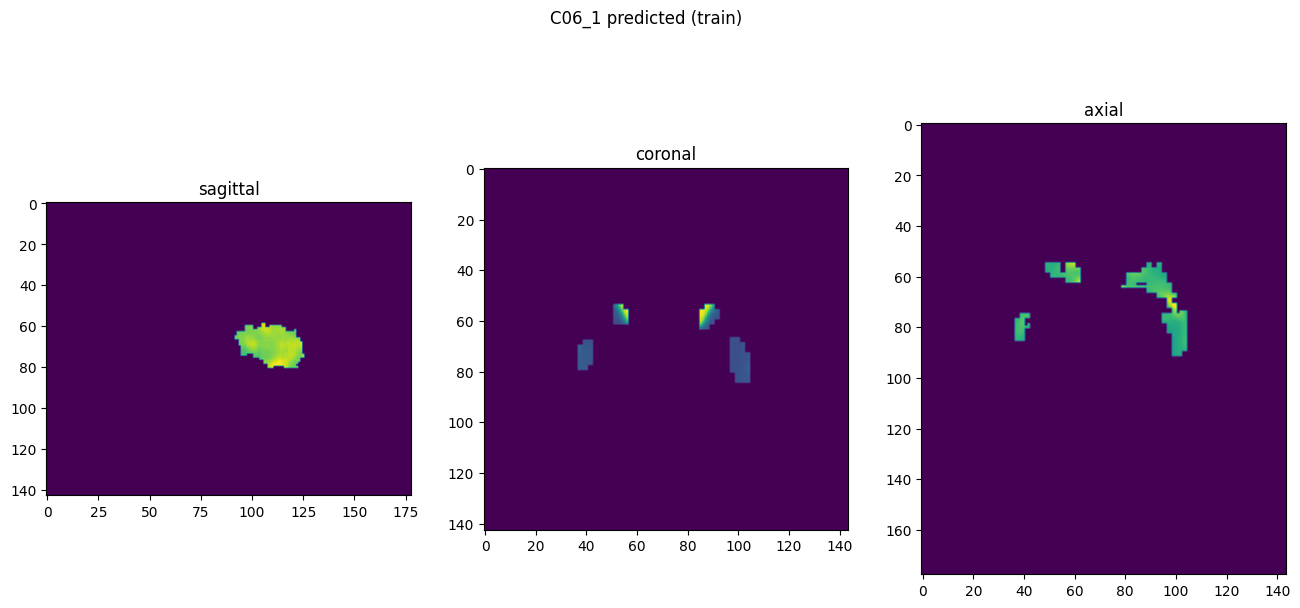

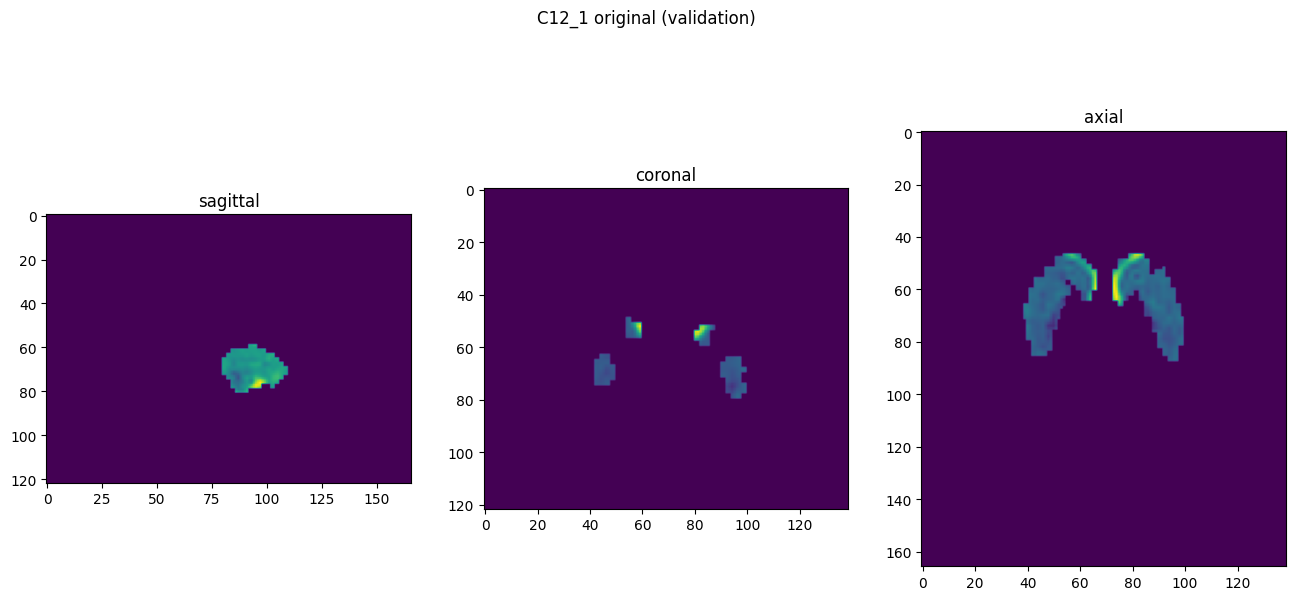

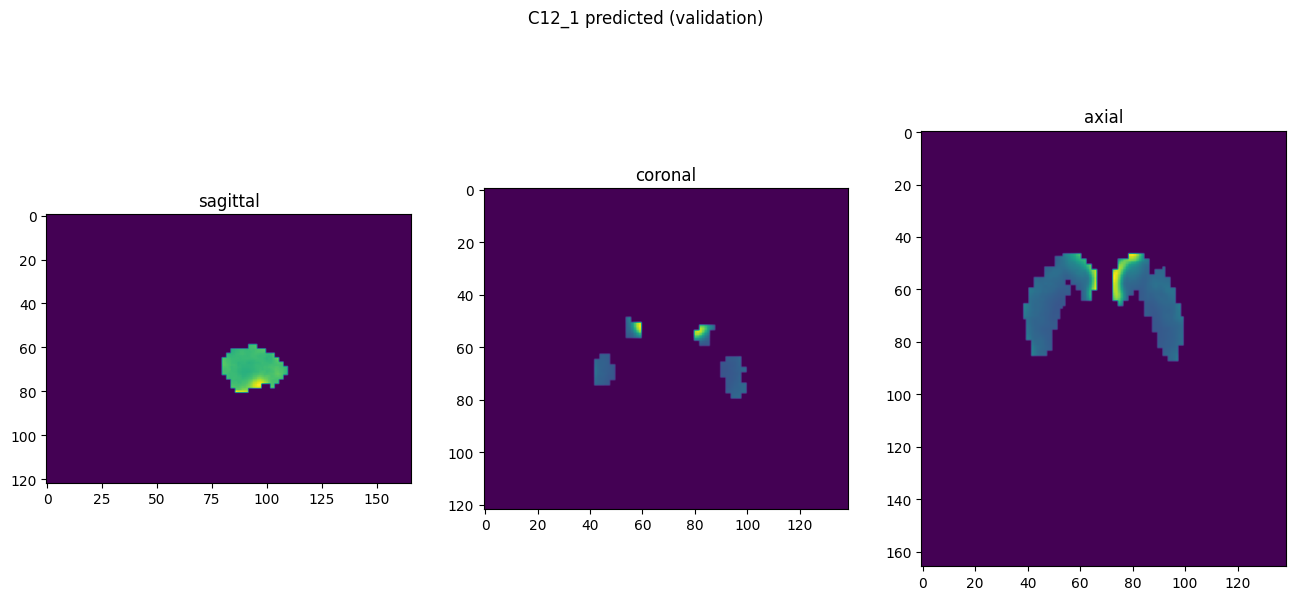

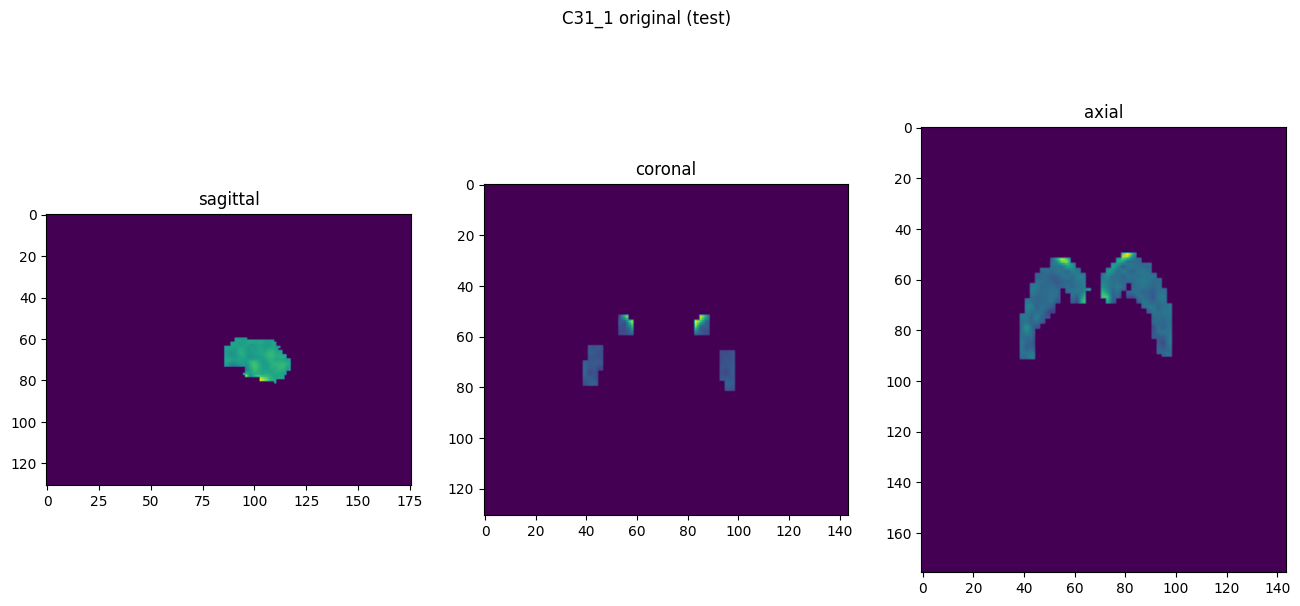

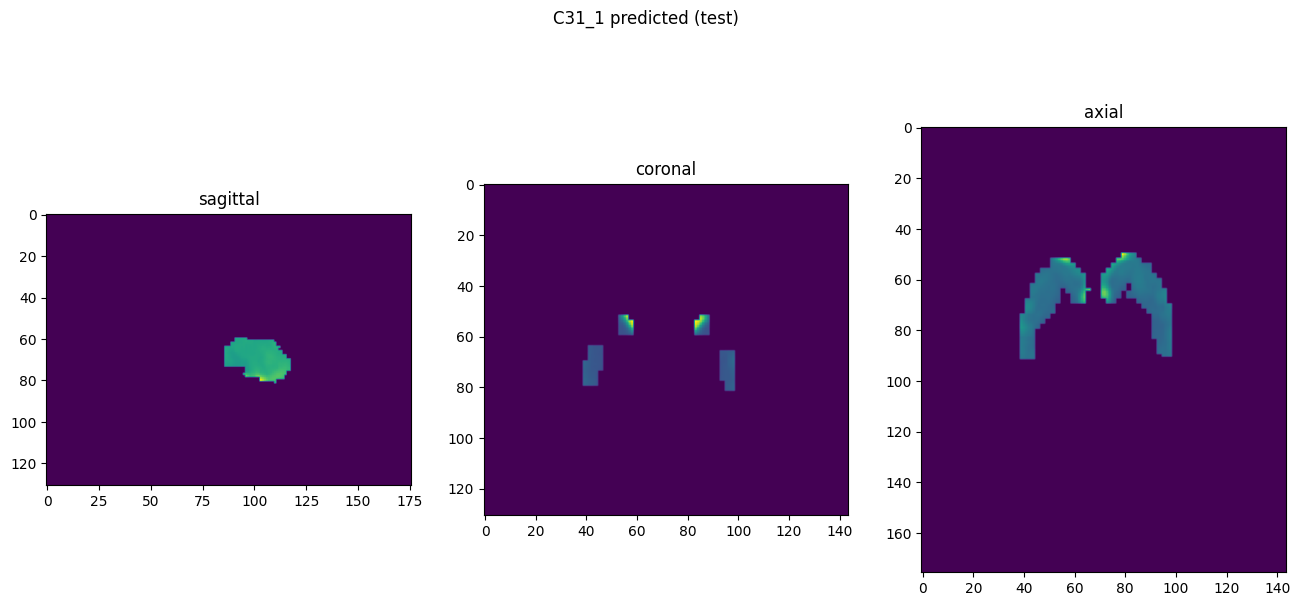

In [10]:
showResults(model, gen, threshold=None, background=False)